# [Yelp Dataset Challenge](http://www.yelp.com/dataset_challenge)
**Rakesh Chada** and **Chetan Naik**

---

**Models**
- [Baseline Model](#baseline)
- [Naive-Bayes Model](#nbmodel)
- [LDA Model](#ldamodel)
- [LDA + Sentiment Model](#ldasentimentmodel)

---

#### 1.1 Importing necessary libraries

In [43]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [44]:
import time
import datetime

import cPickle as pickle
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pylab
import re
import scipy as sp
import seaborn

from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

plt.rc('figure', figsize=(10,6))
seaborn.set()
colors = seaborn.color_palette()

#### 1.2 Read csv files using pandas library.

In [45]:
business_data = pd.read_csv('yelp_academic_dataset_business.csv', dtype=unicode)
checkin_data = pd.read_csv('yelp_academic_dataset_checkin.csv')
review_data = pd.read_csv('yelp_academic_dataset_review.csv')
tip_data = pd.read_csv('yelp_academic_dataset_tip.csv')
user_data = pd.read_csv('yelp_academic_dataset_user.csv')

#### 1.3 Merge pandas dataframes.

In [46]:
review_user_data = review_data.merge(user_data,
                                     left_on='user_id',
                                     right_on='user_id',
                                     how='outer',
                                     suffixes=('_review', '_user'))

In [47]:
business_review_user_data = review_user_data.merge(business_data,
                                                   left_on='business_id',
                                                   right_on='business_id',
                                                   how='outer',
                                                   suffixes=('_reviewuser', '_business'))

In [48]:
business_review_user_data = business_review_user_data.rename(columns = {'name_reviewuser':'name_user',
                                                                        'review_count_reviewuser':'review_count_user',
                                                                        'stars_reviewuser':'stars_review'})

In [49]:
cols = business_review_user_data.columns
cols = cols.map(lambda x: x.replace(' ', '_').lower() if isinstance(x, (str, unicode)) else x)
business_review_user_data.columns = cols
firstFewRows = business_review_user_data.ix[:,['categories','text','stars_review','business_id']]
firstFewRowsList = firstFewRows['categories'].tolist()
restaurantsDF = firstFewRows[firstFewRows['categories'].str.contains('Restaurants')]

In [60]:
# t = restaurantsDF[.groupby('categories').count()]
# t = restaurantsDF[['text','stars_review']]

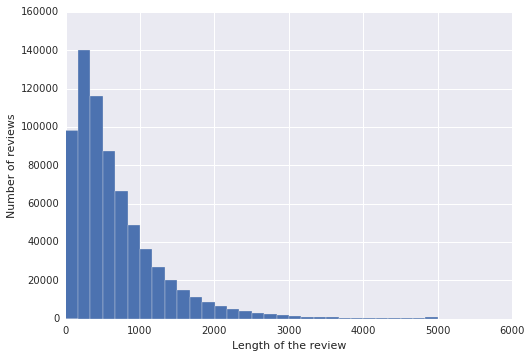

In [77]:
restaurantsDF.text.dropna().str.len().hist(bins=30)
xlabel('Length of the review')
ylabel('Number of reviews')

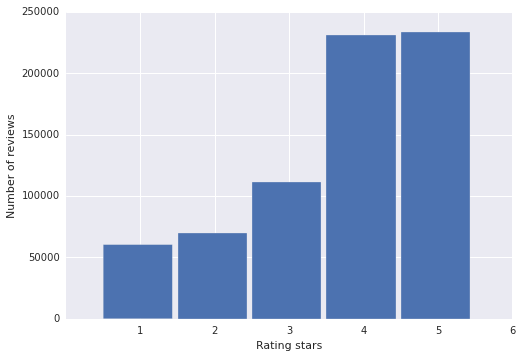

In [95]:
bins = [1, 2,3 ,4, 5, 6]
restaurantsDF.stars_review.hist(bins=bins, align='left', width=0.93)
xticks(bins)
xlabel('Rating stars')
ylabel('Number of reviews')
plt.show()

## Functions to plot error metrics

In [96]:
def central_tendency_plot(point, ci, y, color, label):
    plt.plot(ci, [y, y], "-", color=color, linewidth=4, label=label)
    plt.plot(point, y, "o", color=color, markersize=10)
    
def plot_error_dist(column, name):
    d = column.tolist()
    d = [0 if math.isnan(x) else x for x in d]
    m = mean(d)
    med = median(d)
    s = std(d)

    x = linspace(min(d), max(d), 1000)
    gauss = lambda x, m, s: (1 / (s * sqrt(2 * pi)) * exp(-0.5 * ((x - m) / s) ** 2))
    y = gauss(x, m, s)

    bins = np.arange(min(d), max(d)+1, 1)
    n, b, patches = plt.hist(d, bins=bins+1, normed=True, align='left', width=0.95)
    xticks(bins)
    bin_max = np.max(n)
    m_y = bin_max/5
    
    central_tendency_plot(m, [m - s, m + s], m_y, colors[1], "std dev")

    ci = np.percentile(d, [16, 84])
    central_tendency_plot(med, ci,  m_y - bin_max/10, colors[2], "68% CI")
    
    plt.legend(loc=0)
    plt.plot(x, y, color=colors[4])
    plt.xlabel('Error')
    plt.ylabel('Normalized Frequency')
    title = name + ' Error Distribution'
    plt.title(title)
    plt.show()

## <a id='baseline'>1. Baseline Model</a>

Assign average rating as the predicted rating.

In [97]:
restaurantsDF['predicted_rating'] = round(sum(restaurantsDF.stars_review)/len(restaurantsDF.index))

In [98]:
restaurantsDF['predicted_rating'] = round(sum(restaurantsDF.stars_review)/len(restaurantsDF.index))

print "Baseline Rating:", round(sum(restaurantsDF.stars_review)/len(restaurantsDF.index))

Baseline Rating: 4.0


In [99]:
t = restaurantsDF[['stars_review', 'predicted_rating']].dropna(how='any')

In [100]:
precision = metrics.precision_score(t.stars_review, t.predicted_rating)
recall = metrics.recall_score(t.stars_review, t.predicted_rating)
f1 = metrics.f1_score(t.stars_review, t.predicted_rating)
accuracy = accuracy_score(t.stars_review, t.predicted_rating)

baselineResult = {}

data = {'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'accuracy':accuracy}

baselineResult['Baseline'] = data
pd.DataFrame(baselineResult).T

,accuracy,f1_score,precision,recall
Baseline,0.327417,0.16152,0.107202,0.327417


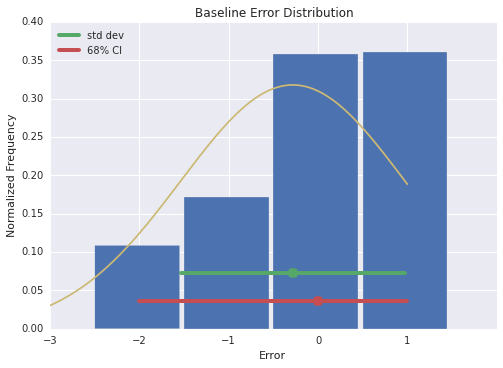

In [101]:
error = restaurantsDF.stars_review - restaurantsDF.predicted_rating
plot_error_dist(error, "Baseline")

# Advanced models

Preparing data.

Obtain the list of all stop words

In [14]:
stoplist = set(stopwords.words("english"))

In [15]:
numTopics = 15

Implement the following using pandas utilities.

In [16]:
t = restaurantsDF.dropna(how='all')

In [17]:
minReviewLen = 50
maxReviewLen = 100

print "Number of rows selected:",len(t[t.text.str.len() > minReviewLen][t.text.str.len() < maxReviewLen])
restaurantsDF = t[t.text.str.len() > minReviewLen][t.text.str.len() < maxReviewLen]

Number of rows selected: 28148


/Library/Python/2.7/site-packages/pandas-0.13.1_213_gc174c3d-py2.7-macosx-10.9-intel.egg/pandas/core/frame.py:1695: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [18]:
def perform_lda(allReviewsTrain, numTopics):
    corpus = []
    for review in allReviewsTrain:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            corpus.append(texts)
        except:
            pass

    # Build dictionary
    dictionary = corpora.Dictionary(corpus)
    dictionary.save('restaurant_reviews.dict')
        
    # Build vectorized corpus
    corpus_2 = [dictionary.doc2bow(text) for text in corpus]
    #corpora.MmCorpus.serialize('LDA/restaurant_reviews.mm', corpus_2)
    
    lda = models.LdaModel(corpus_2, num_topics=numTopics, id2word=dictionary)
    return lda

### Process the reviews and generate a topic distribution matrix (to be used as features in classification)

In [19]:
def process_reviews(dirty_data_set):
    clean_data_set = []
    for review in dirty_data_set:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            clean_data_set.append(' '.join(texts))
        except:
            pass
    return clean_data_set

# Generates a matrix of topic probabilities for each document in matrix
# Returns topic_dist for the input corpus, and all_dist, a running sum of all the corpuses
def generate_topic_dist_matrix(lda, numTopics, corpus, all_dist, star):
    topic_dist = [0] * numTopics
    dictionary = corpora.Dictionary.load("restaurant_reviews.dict")
    for doc in corpus:
        vec = dictionary.doc2bow(doc.lower().split())
        output = lda[vec]
        highest_prob = 0
        highest_topic = 0
        temp = [0] * numTopics    # List to keep track of topic distribution for each document
        for topic in output:
            this_topic, this_prob = topic
            temp[this_topic] = this_prob
            if this_prob > highest_prob:
                highest_prob = this_prob 
                highest_topic = this_topic
        temp.append(star)
        all_dist.append(temp)
        topic_dist[highest_topic] += 1
    return topic_dist, all_dist

### Construct 5 groups for each rating

In [20]:
starsGroup = restaurantsDF.groupby('stars_review')

all_1stars_text = starsGroup.get_group(1.0)['text']
all_2stars_text = starsGroup.get_group(2.0)['text']
all_3stars_text = starsGroup.get_group(3.0)['text']
all_4stars_text = starsGroup.get_group(4.0)['text']
all_5stars_text = starsGroup.get_group(5.0)['text']

all_1stars_labels = [1.0]*len(all_1stars_text)
all_2stars_labels = [2.0]*len(all_2stars_text)
all_3stars_labels = [3.0]*len(all_3stars_text)
all_4stars_labels = [4.0]*len(all_4stars_text)
all_5stars_labels = [5.0]*len(all_5stars_text)

###Split into training and testing data randomly using sklearn's library

In [21]:
from sklearn.cross_validation import train_test_split

all_1stars_text_train, all_1stars_text_test, all_1stars_labels_train, all_1stars_labels_test = train_test_split(all_1stars_text, all_1stars_labels, test_size=0.20)
all_2stars_text_train, all_2stars_text_test, all_2stars_labels_train, all_2stars_labels_test = train_test_split(all_2stars_text, all_2stars_labels, test_size=0.20)
all_3stars_text_train, all_3stars_text_test, all_3stars_labels_train, all_3stars_labels_test = train_test_split(all_3stars_text, all_3stars_labels, test_size=0.20)
all_4stars_text_train, all_4stars_text_test, all_4stars_labels_train, all_4stars_labels_test = train_test_split(all_4stars_text, all_4stars_labels, test_size=0.20)
all_5stars_text_train, all_5stars_text_test, all_5stars_labels_train, all_5stars_labels_test = train_test_split(all_5stars_text, all_5stars_labels, test_size=0.20)

In [22]:
# Process the reviews
corpus_5stars = process_reviews(all_5stars_text_train)
corpus_4stars = process_reviews(all_4stars_text_train)
corpus_3stars = process_reviews(all_3stars_text_train)
corpus_2stars = process_reviews(all_2stars_text_train)
corpus_1stars = process_reviews(all_1stars_text_train)

print "Number of 5-star reviews after processing: ", len(corpus_5stars)
print "Number of 4-star reviews after processing: ", len(corpus_4stars)
print "Number of 3-star reviews after processing: ", len(corpus_3stars)
print "Number of 2-star reviews after processing: ", len(corpus_2stars)
print "Number of 1-star reviews after processing: ", len(corpus_1stars)

Number of 5-star reviews after processing:  10082
Number of 4-star reviews after processing:  7177
Number of 3-star reviews after processing:  2492
Number of 2-star reviews after processing:  1260
Number of 1-star reviews after processing:  1505


In [23]:
all_5_4_train = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_train = np.append(all_5_4_train, corpus_3stars)
all_5_4_3_2_train = np.append(all_5_4_3_train, corpus_2stars)
all_text_train = np.append(all_5_4_3_2_train, corpus_1stars)

# pickle.dump(all_text_train, open("all_text_train.p", "wb"))

In [24]:
%time lda = perform_lda(all_text_train, numTopics)
# pickle.dump(lda, open("lda.p", "wb"))

CPU times: user 29.7 s, sys: 1.2 s, total: 30.9 s
Wall time: 32.6 s


### Build the final data frame containing topic distribution for each set of rating

In [25]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []

topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in xrange(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_train_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)

# pickle.dump(topic_dist_train_1_2_3_4_5_df, open("topic_dist_train_1_2_3_4_5_df.p", "wb"))

Get topic distribution of test data.

In [26]:
# Process the test reviews
corpus_5stars = process_reviews(all_5stars_text_test)
corpus_4stars = process_reviews(all_4stars_text_test)
corpus_3stars = process_reviews(all_3stars_text_test)
corpus_2stars = process_reviews(all_2stars_text_test)
corpus_1stars = process_reviews(all_1stars_text_test)

print "Number of 5-star reviews after processing: ", len(corpus_5stars)
print "Number of 4-star reviews after processing: ", len(corpus_4stars)
print "Number of 3-star reviews after processing: ", len(corpus_3stars)
print "Number of 2-star reviews after processing: ", len(corpus_2stars)
print "Number of 1-star reviews after processing: ", len(corpus_1stars)

Number of 5-star reviews after processing:  2521
Number of 4-star reviews after processing:  1795
Number of 3-star reviews after processing:  624
Number of 2-star reviews after processing:  315
Number of 1-star reviews after processing:  377


In [27]:
all_5_4_test = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_test = np.append(all_5_4_test, corpus_3stars)
all_5_4_3_2_test = np.append(all_5_4_3_test, corpus_2stars)
all_text_test = np.append(all_5_4_3_2_test, corpus_1stars)

# pickle.dump(all_text_test, open("all_text_test.p", "wb"))

In [28]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []


topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in xrange(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_test_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)

# pickle.dump(topic_dist_test_1_2_3_4_5_df, open("topic_dist_test_1_2_3_4_5_df.p", "wb"))

In [29]:
topic_dist_test_1_2_3_4_5_df.shape

(5632, 16)

In [30]:
topic_dist_train_1_2_3_4_5_df.shape

(22516, 16)

#### Add sentiment label which will be used to train sentiment classifier

In [31]:
def getSentiment(x):
    if x < 3.5:
        return 0
    else:
        return 1

In [32]:
topic_dist_train_1_2_3_4_5_df['Sentiment'] = topic_dist_train_1_2_3_4_5_df['Star'].map(getSentiment)
topic_dist_test_1_2_3_4_5_df['Sentiment'] = topic_dist_test_1_2_3_4_5_df['Star'].map(getSentiment)

In [33]:
# pickle.dump(topic_dist_train_1_2_3_4_5_df, open("topic_dist_train_1_2_3_4_5_df.p", "wb"))
# pickle.dump(topic_dist_test_1_2_3_4_5_df, open("topic_dist_test_1_2_3_4_5_df.p", "wb"))

## <a id='nbmodel'>2. Naive-Bayes Model</a>
Using intuitive idea of term frequency to extract features and then using Naive-Bayes classifier to predict ratings.

In [34]:
vectorizer = TfidfVectorizer()

tfidfXtrain = vectorizer.fit_transform(all_text_train)
tfidfXtest = vectorizer.transform(all_text_test)

tfidfYtrain = topic_dist_train_1_2_3_4_5_df['Star']
tfidfYtest = topic_dist_test_1_2_3_4_5_df['Star']

In [35]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression()]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression']

NBResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(tfidfXtrain, tfidfYtrain)
    preds = clf.predict(tfidfXtest)
    
    precision = metrics.precision_score(tfidfYtest, preds)
    recall = metrics.recall_score(tfidfYtest, preds)
    f1 = metrics.f1_score(tfidfYtest, preds)
    accuracy = accuracy_score(tfidfYtest, preds)
    report = classification_report(tfidfYtest, preds)
    matrix = metrics.confusion_matrix(tfidfYtest, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    NBResults[clf_names[i]] = data

cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(NBResults).T[cols].T

,Logistic Regression,Multinomial Naive Bayes,Nearest Neighbors
precision,0.5666007,0.512081,0.4812704
recall,0.5788352,0.5150923,0.4971591
f1_score,0.5542841,0.4375616,0.4856319
accuracy,0.5788352,0.5150923,0.4971591


In [36]:
for model, val in NBResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'Here is the classification report:'
    print val['clf_report']

--------------------------
MODEL: Logistic Regression
--------------------------
The precision for this classifier is 0.566600729631
The recall for this classifier is    0.578835227273
The f1 for this classifier is        0.554284112925
The accuracy for this classifier is  0.578835227273
Here is the classification report:
             precision    recall  f1-score   support

          1       0.65      0.53      0.58       377
          2       0.60      0.11      0.19       315
          3       0.47      0.24      0.32       624
          4       0.49      0.47      0.48      1795
          5       0.63      0.81      0.71      2521

avg / total       0.57      0.58      0.55      5632

------------------------
MODEL: Nearest Neighbors
------------------------
The precision for this classifier is 0.481270411678
The recall for this classifier is    0.497159090909
The f1 for this classifier is        0.485631929129
The accuracy for this classifier is  0.497159090909
Here is the classif

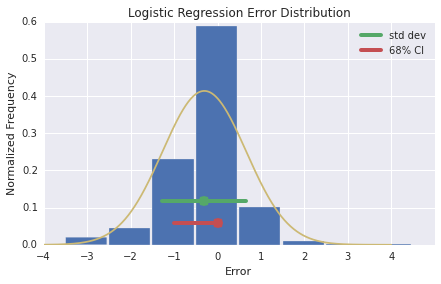

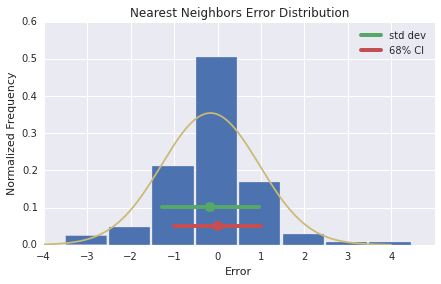

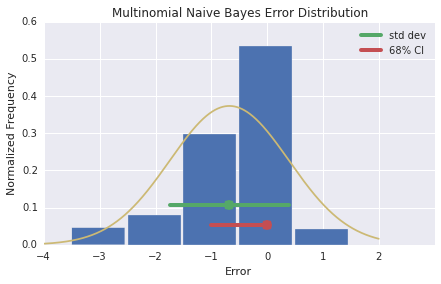

In [37]:
for model, val in NBResults.iteritems():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    
    test_data = pd.DataFrame(y_predicted, columns=['predicted_rating'])
    test_data['rating'] = tfidfYtest

    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)

---
## <a id='ldamodel'>3. LDA Model</a>
To reduce processing of redundant information that we did on term frequency method, we are using topic modeling to extract major topics in a review and using that as features.

In [38]:
features = list(topic_dist_train_1_2_3_4_5_df.columns[:numTopics])
print features

['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15']


In [39]:
x_train = topic_dist_train_1_2_3_4_5_df[features]
y_train = topic_dist_train_1_2_3_4_5_df['Star']

x_test = topic_dist_test_1_2_3_4_5_df[features]
y_test = topic_dist_test_1_2_3_4_5_df['Star'] 

clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), LDA(), QDA(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression', 'LDA', 'QDA', 'Random Forest', 'AdaBoost']

LDAResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds)
    recall = metrics.recall_score(y_test, preds)
    f1 = metrics.f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    LDAResults[clf_names[i]] = data

/usr/local/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(LDAResults).T[cols].T

,AdaBoost,LDA,Logistic Regression,Multinomial Naive Bayes,Nearest Neighbors,QDA,Random Forest
precision,0.3870217,0.3402673,0.3319078,0.2003643,0.3624068,0.4008231,0.3602786
recall,0.4501065,0.4493963,0.4492188,0.4476207,0.3723366,0.3840554,0.4067827
f1_score,0.3876636,0.3355019,0.3278586,0.2768188,0.3661137,0.3681859,0.3774552
accuracy,0.4501065,0.4493963,0.4492188,0.4476207,0.3723366,0.3840554,0.4067827


In [41]:
for model, val in LDAResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'Here is the classification report:'
    print val['clf_report']

----------
MODEL: LDA
----------
The precision for this classifier is 0.340267341469
The recall for this classifier is    0.449396306818
The f1 for this classifier is        0.335501948106
The accuracy for this classifier is  0.449396306818
Here is the classification report:
             precision    recall  f1-score   support

          1       0.15      0.01      0.02       377
          2       0.00      0.00      0.00       315
          3       0.00      0.00      0.00       624
          4       0.39      0.13      0.19      1795
          5       0.46      0.91      0.61      2521

avg / total       0.34      0.45      0.34      5632

----------
MODEL: QDA
----------
The precision for this classifier is 0.400823103628
The recall for this classifier is    0.384055397727
The f1 for this classifier is        0.368185864045
The accuracy for this classifier is  0.384055397727
Here is the classification report:
             precision    recall  f1-score   support

          1       0.

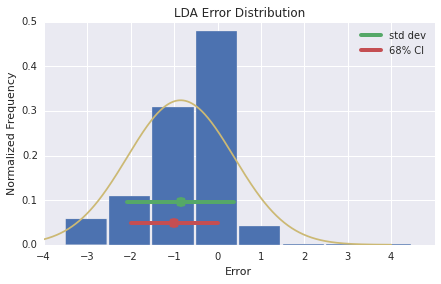

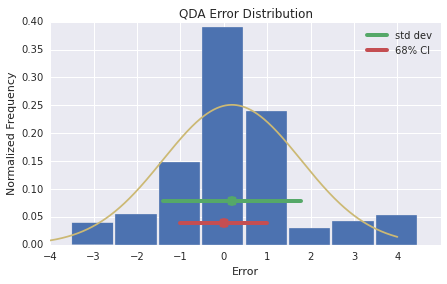

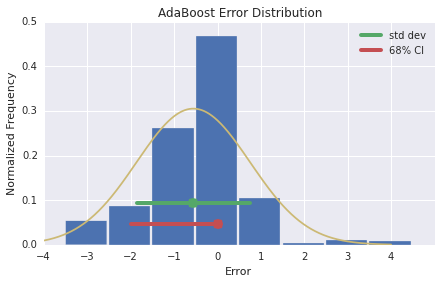

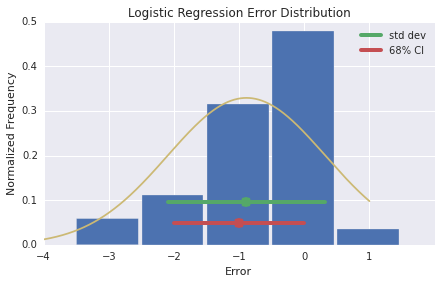

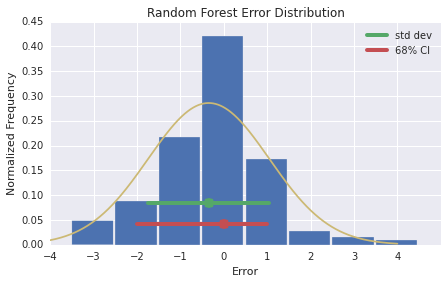

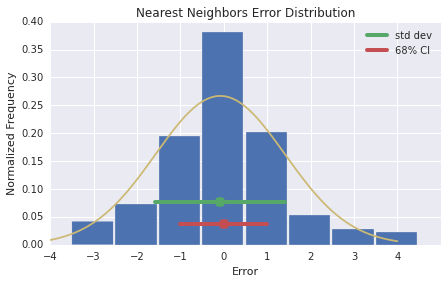

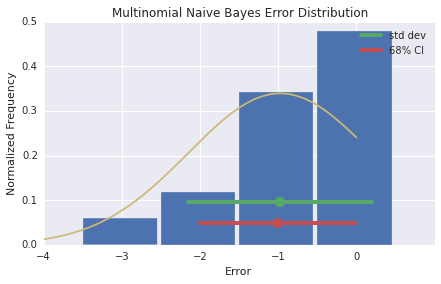

In [42]:
for model, val in LDAResults.iteritems():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    
    test_data = pd.DataFrame(y_predicted, columns=['predicted_rating'])
    test_data['rating'] = tfidfYtest

    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)

---
This is not giving expected accuracy because some topics, though they seem similar have different sentiments. So adding a sentimnt layer.

## Adding Sentiment Column using Logistic Regression

In [43]:
sentimentXtrain = vectorizer.fit_transform(all_text_train)
sentimentXtest = vectorizer.transform(all_text_test)

sentimentYtrain = topic_dist_train_1_2_3_4_5_df['Sentiment']
sentimentYtest = topic_dist_test_1_2_3_4_5_df['Sentiment']

nb_classifier = LogisticRegression().fit(sentimentXtrain, sentimentYtrain)

ySentimentTrain = nb_classifier.predict(sentimentXtrain)
ySentimentTest = nb_classifier.predict(sentimentXtest)

topic_dist_train_1_2_3_4_5_df['Sentiment_Predicted'] = ySentimentTrain
topic_dist_test_1_2_3_4_5_df['Sentiment_Predicted'] = ySentimentTest

In [44]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression()]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression']

SentimentResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(sentimentXtrain, sentimentYtrain)
    preds = clf.predict(sentimentXtest)
    
    precision = metrics.precision_score(sentimentYtest, preds)
    recall = metrics.recall_score(sentimentYtest, preds)
    f1 = metrics.f1_score(sentimentYtest, preds)
    accuracy = accuracy_score(sentimentYtest, preds)
    report = classification_report(sentimentYtest, preds)
    matrix = metrics.confusion_matrix(sentimentYtest, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    SentimentResults[clf_names[i]] = data
    
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(SentimentResults).T[cols].T

,Logistic Regression,Multinomial Naive Bayes,Nearest Neighbors
precision,0.8779818,0.8247641,0.8378105
recall,0.9636237,0.992354,0.9610751
f1_score,0.9188114,0.9008308,0.8952196
accuracy,0.8694957,0.8325639,0.8275923


In [45]:
for model, val in SentimentResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'Here is the classification report:'
    print val['clf_report']

--------------------------
MODEL: Logistic Regression
--------------------------
The precision for this classifier is 0.87798184505
The recall for this classifier is    0.963623725672
The f1 for this classifier is        0.91881144372
The accuracy for this classifier is  0.869495738636
Here is the classification report:
             precision    recall  f1-score   support

          0       0.82      0.56      0.67      1316
          1       0.88      0.96      0.92      4316

avg / total       0.87      0.87      0.86      5632

------------------------
MODEL: Nearest Neighbors
------------------------
The precision for this classifier is 0.837810543325
The recall for this classifier is    0.961075069509
The f1 for this classifier is        0.895219596417
The accuracy for this classifier is  0.827592329545
Here is the classification report:
             precision    recall  f1-score   support

          0       0.75      0.39      0.51      1316
          1       0.84      0.96      

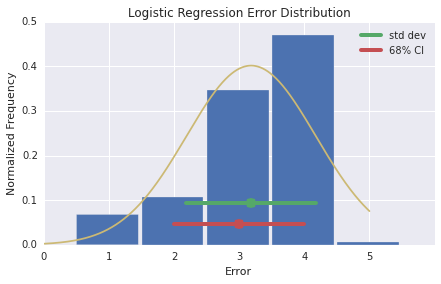

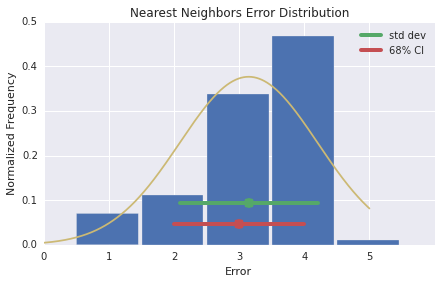

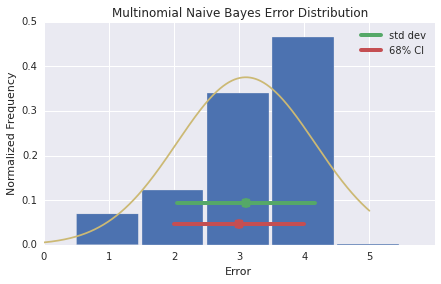

In [46]:
for model, val in SentimentResults.iteritems():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    
    test_data = pd.DataFrame(y_predicted, columns=['predicted_rating'])
    test_data['rating'] = tfidfYtest

    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)

---
## <a id='ldasentimentmodel'>4. LDA + Sentiment Model</a>

In [47]:
features = list(topic_dist_train_1_2_3_4_5_df.columns[:numTopics])
features.append(topic_dist_train_1_2_3_4_5_df.columns[numTopics+2])
print features

['Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'Topic6', 'Topic7', 'Topic8', 'Topic9', 'Topic10', 'Topic11', 'Topic12', 'Topic13', 'Topic14', 'Topic15', 'Sentiment_Predicted']


In [48]:
x_train = topic_dist_train_1_2_3_4_5_df[features]
y_train = topic_dist_train_1_2_3_4_5_df['Star']

x_test = topic_dist_test_1_2_3_4_5_df[features]
y_test = topic_dist_test_1_2_3_4_5_df['Star'] 

clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), LDA(), QDA(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression', 'LDA', 'QDA', 'Random Forest', 'AdaBoost']

FinalResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds)
    recall = metrics.recall_score(y_test, preds)
    f1 = metrics.f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    FinalResults[clf_names[i]] = data

In [49]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(FinalResults).T[cols].T

,AdaBoost,LDA,Logistic Regression,Multinomial Naive Bayes,Nearest Neighbors,QDA,Random Forest
precision,0.4569977,0.4162115,0.4445892,0.2003643,0.4260344,0.4671447,0.4447251
recall,0.4870384,0.4921875,0.4978693,0.4476207,0.4383878,0.4980469,0.4641335
f1_score,0.4597855,0.3915342,0.394179,0.2768188,0.4305247,0.4505046,0.4504848
accuracy,0.4870384,0.4921875,0.4978693,0.4476207,0.4383878,0.4980469,0.4641335


In [50]:
for model, val in FinalResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'Here is the classification report:'
    print val['clf_report']

----------
MODEL: LDA
----------
The precision for this classifier is 0.416211541206
The recall for this classifier is    0.4921875
The f1 for this classifier is        0.391534215653
The accuracy for this classifier is  0.4921875
Here is the classification report:
             precision    recall  f1-score   support

          1       0.33      0.71      0.45       377
          2       0.34      0.08      0.12       315
          3       0.00      0.00      0.00       624
          4       0.43      0.11      0.17      1795
          5       0.53      0.91      0.67      2521

avg / total       0.42      0.49      0.39      5632

----------
MODEL: QDA
----------
The precision for this classifier is 0.467144744169
The recall for this classifier is    0.498046875
The f1 for this classifier is        0.450504558679
The accuracy for this classifier is  0.498046875
Here is the classification report:
             precision    recall  f1-score   support

          1       0.36      0.51    

---

## Error Metrics

In [51]:
# Train Data
data_1stars_train = {"text": all_1stars_text_train, "rating": all_1stars_labels_train}
data_1stars_train = pd.DataFrame(data_1stars_train)

data_2stars_train = {"text": all_2stars_text_train, "rating": all_2stars_labels_train}
data_2stars_train = pd.DataFrame(data_2stars_train)

data_3stars_train = {"text": all_3stars_text_train, "rating": all_3stars_labels_train}
data_3stars_train = pd.DataFrame(data_3stars_train)

data_4stars_train = {"text": all_4stars_text_train, "rating": all_4stars_labels_train}
data_4stars_train = pd.DataFrame(data_4stars_train)

data_5stars_train = {"text": all_5stars_text_train, "rating": all_5stars_labels_train}
data_5stars_train = pd.DataFrame(data_5stars_train)

# Test Data
data_1stars_test = {"text": all_1stars_text_test, "rating": all_1stars_labels_test}
data_1stars_test = pd.DataFrame(data_1stars_test)

data_2stars_test = {"text": all_2stars_text_test, "rating": all_2stars_labels_test}
data_2stars_test = pd.DataFrame(data_2stars_test)

data_3stars_test = {"text": all_3stars_text_test, "rating": all_3stars_labels_test}
data_3stars_test = pd.DataFrame(data_3stars_test)

data_4stars_test = {"text": all_4stars_text_test, "rating": all_4stars_labels_test}
data_4stars_test = pd.DataFrame(data_4stars_test)

data_5stars_test = {"text": all_5stars_text_test, "rating": all_5stars_labels_test}
data_5stars_test = pd.DataFrame(data_5stars_test)

In [52]:
train_pieces = [data_1stars_train, data_2stars_train, data_3stars_train, data_4stars_train, data_5stars_train]
train_data = pd.concat(train_pieces, ignore_index=True)
train_data['predicted_rating'] = pd.Series('training_data', index=train_data.index)
print "Train Data", len(train_data)

test_pieces = [data_1stars_test, data_2stars_test, data_3stars_test, data_4stars_test, data_5stars_test]
test_data = pd.concat(test_pieces, ignore_index=True)
print "Test Data", len(test_data)

Train Data 22516
Test Data 5632


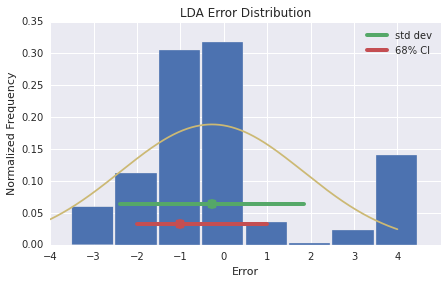

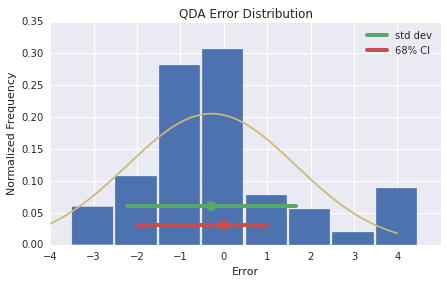

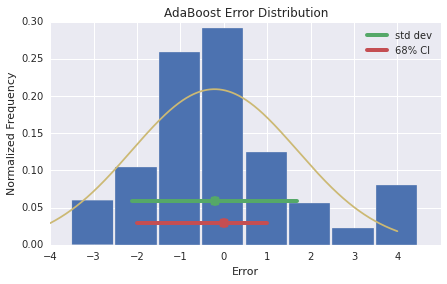

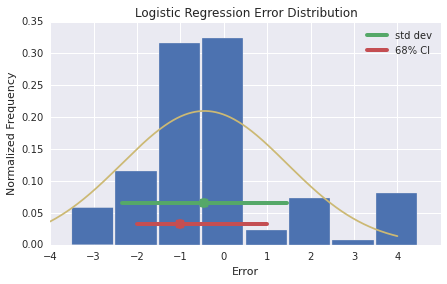

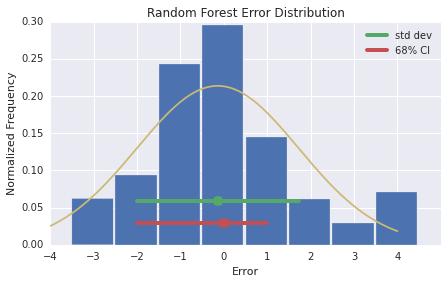

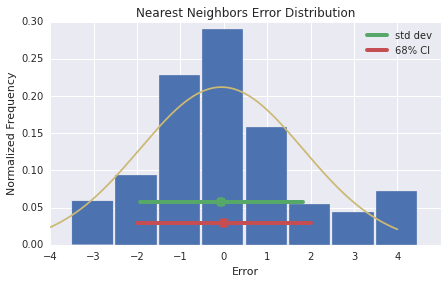

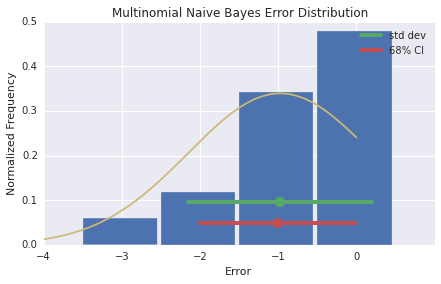

In [53]:
for model, val in FinalResults.iteritems():
    plt.rc('figure', figsize=(7,4))
    y_predicted = val['y_predicted']
    test_data['predicted_rating'] = pd.Series(y_predicted)
    pieces = [train_data, test_data]
    all_data = pd.concat(pieces, ignore_index=True)
    test_data['error'] = test_data.rating - test_data.predicted_rating
    plot_error_dist(test_data.error, model)